In [32]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import *
from  scipy import stats
from sklearn.model_selection import cross_val_score
from category_encoders import TargetEncoder
import math
import pickle


## Weather Data PRE-PROCESSING

In [33]:
encoder = TargetEncoder()
weatheDf = pd.read_csv("weather.csv")
weatheDf["encodedlocation"] = encoder.fit_transform(weatheDf['location'], weatheDf['rain'])
weatheDf.time_stamp = pd.to_datetime(weatheDf.time_stamp,unit='s')


#### remove time_stamp and replace it with hour and month columns instead

In [34]:
#weatheDf.month = weatheDf.time_stamp.dt.month
weatheDf['month'] = weatheDf.time_stamp.dt.month
weatheDf.time_stamp = weatheDf.time_stamp.dt.hour
weatheDf =  weatheDf.rename(
    columns ={
        'time_stamp':'hour'
    }
    )

In [35]:
weatheDf.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'hour', 'humidity',
       'wind', 'encodedlocation', 'month'],
      dtype='object')

#### Scale the data using minMaxScaler

In [36]:
scaler = MinMaxScaler()
scaler.fit(weatheDf.drop(['rain','location'],axis=1))
#wweatheDf = pd.DataFrame(scaler.transform(weatheDf.drop('rain',axis=1)), columns= weatheDf.drop('rain',axis=1).columns)
weatheDf1 =weatheDf.copy()
weatheDf.dropna(axis=0,inplace=True)
X = weatheDf.drop(['rain','location'],axis=1)
y = weatheDf.rain
x_pred = weatheDf1.drop(['rain','location'],axis=1)

#### Train the model to predict the missing values of rain feature

In [37]:
model = linear_model.LinearRegression()
poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X)
x_pred_poly = poly_features.fit_transform(x_pred)
model.fit(X_train_poly, y)
y_train_predicted = model.predict(x_pred_poly)


In [38]:
y_train_predicted.shape
y_train_predicted
weatheDf1.rain = y_train_predicted


In [39]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.8,frac_test=0.2,
                                         random_state=None):
    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

 

    assert len(df_input) == len(df_train) + len(df_temp)

    return df_train, df_temp

In [40]:
def Feature_Encoder(X, cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
    return X


In [41]:
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df


## working on the Main Dataset

In [42]:
def test_sample(sampleData):
    poly_features = pickle.load(open("poly_features.pkl", "rb"))
    sampleData.drop(['id'], axis=1, inplace=True)
    y_tru = sampleData['price']
    sampleData = sampleData[top_feature]
    sampleData.drop(['price'], axis=1, inplace=True)
    for col in sampleData.select_dtypes(include='O').columns:
        encoder = pickle.load(open(col + '.pkl', 'rb'))
        sampleData[col] = encoder.transform(sampleData[col])
    scaler = pickle.load(open('scaler.pkl', 'rb'))
    scaler.fit(sampleData)
    sampleData = pd.DataFrame(scaler.transform(sampleData))
    sampleData = poly_features.transform(sampleData)
    clrf = pickle.load(open('linear.pkl', 'rb'))
    sample_pred = clrf.predict(sampleData)
    print('linear acc', metrics.r2_score(y_tru, sample_pred)* 100.0)


In [43]:
weatherData =weatheDf1.drop('encodedlocation',axis=1)
taxiRidersData = pd.read_csv("taxi-rides.csv")
taxiRidersData.time_stamp = pd.to_datetime(taxiRidersData.time_stamp,unit="ms")
#taxiRidersData.month =taxiRidersData.time_stamp.dt.month
taxiRidersData['month']=(taxiRidersData.time_stamp.dt.month)
taxiRidersData.time_stamp = taxiRidersData.time_stamp.dt.hour
taxiRidersData.rename(
    columns ={
        'time_stamp':'hour'
    }
)


,distance,cab_type,hour,destination,source,surge_multiplier,id,product_id,name,price,month
0,0.62,Uber,6,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,NaN,12
1,2.27,Uber,10,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,8.0,11
2,2.00,Lyft,0,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,10.5,12
3,3.98,Lyft,23,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,lyft_plus,Lyft XL,22.5,11
4,1.49,Lyft,12,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,lyft,Lyft,7.0,11
...,...,...,...,...,...,...,...,...,...,...,...
554451,1.64,Uber,23,Back Bay,Northeastern University,1.0,2aa98e8a-4f06-4ae2-9291-036d74094a1b,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,13.0,11
554452,0.92,Uber,3,North Station,North End,1.0,75cb7a6d-68be-4cc7-b4da-c8e4b997aa8a,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,27.5,11
554453,2.66,Uber,22,Theatre District,Fenway,1.0,569da280-71c6-4459-a343-8573f8613415,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,16.0,11
554454,2.98,Uber,7,Theatre District,Boston University,1.0,71d8a3a6-5b0e-4710-a803-dfd5680a590a,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,11.5,12


In [44]:
taxiRidersData.dropna(axis=0, inplace=True)
avgWeather = weatherData.groupby(["location"]).mean().reset_index(drop=False)
print(taxiRidersData.columns)
avgWeather.drop(['hour'],axis=1,inplace=True)
avgWeather.drop(['month'],axis=1,inplace=True)
sourceWeather = avgWeather.rename(
    columns={
        'location': 'source',
        'rain': 'source_rain',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

destinationWeather = avgWeather.rename(
    columns={
        'location': 'destination',
        'rain': 'destination_rain',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'

    }
)


Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'surge_multiplier', 'id', 'product_id', 'name', 'price', 'month'],
      dtype='object')


In [45]:
data = taxiRidersData.merge(sourceWeather, on='source')\
    .merge(destinationWeather, on="destination")
print(data.columns)

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'surge_multiplier', 'id', 'product_id', 'name', 'price', 'month',
       'source_temp', 'source_clouds', 'source_pressure', 'source_rain',
       'source_humidity', 'source_wind', 'destination_temp',
       'destination_clouds', 'destination_pressure', 'destination_rain',
       'destination_humidity', 'destination_wind'],
      dtype='object')


### DATA PRE-PROCESSING


since product_id and name have 100% correlation we can remove one of them as it is considered dublication

In [46]:
# for i  in ((data.product_id + " " + data.name).unique()):
#     #print(i)
data.drop(['product_id'],axis=1,inplace=True)
data.drop(['id'],axis=1,inplace=True)
print(data.columns)

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'surge_multiplier', 'name', 'price', 'month', 'source_temp',
       'source_clouds', 'source_pressure', 'source_rain', 'source_humidity',
       'source_wind', 'destination_temp', 'destination_clouds',
       'destination_pressure', 'destination_rain', 'destination_humidity',
       'destination_wind'],
      dtype='object')


from the figer we can see that thier are multipl features that are considered highly correlated with each other that we can drop which are:

* source_humidity -> source_temp
* source_wind ->  source_cloud
* destination_humidity -> destination_temp
* destination_wind -> destination_cloud

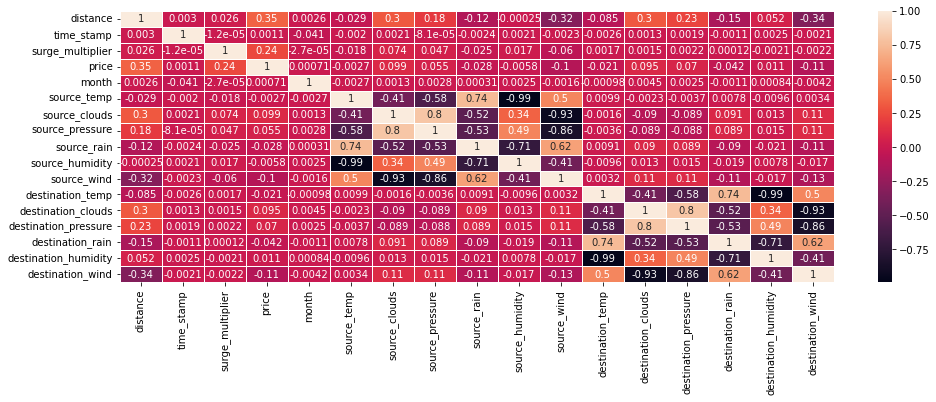

In [47]:
corr = data.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(data.corr(), annot=True, linewidths=1)

In [48]:
dataX = data.drop(['price'],axis=1)
cor_matrix = dataX.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.92)]
print(to_drop)
data = data.drop(to_drop, axis=1)

['source_humidity', 'source_wind', 'destination_humidity', 'destination_wind']


### remove outliers

In [49]:
def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.25,0.75]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

### Encdoing Data

In [50]:
dataTrain,dataTest = split_stratified_into_train_val_test(data,stratify_colname='price', frac_train=0.60, frac_test=0.20)

In [51]:
dataTrain = cap_data(dataTrain)
dataTest = cap_data(dataTest)

/tmp/ipykernel_106646/2223872166.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
/tmp/ipykernel_106646/2223872166.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] >= percentiles[1]] = percentiles[1]
/tmp/ipykernel_106646/2223872166.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
/tmp/ipykernel_106646/222387

Using mean Encdoing to encode data since it has great balance between efficency and model complexity

In [52]:
def mean_encoding(data):
    for col in data.select_dtypes(include='O').columns:
        encoder = TargetEncoder()
        data[col] = encoder.fit_transform(data[col],data['price'])
        pickle.dump(encoder, open(f'{col}.pkl', 'wb'))
    return data


In [53]:
dataTrain = mean_encoding(dataTrain)
dataTest = mean_encoding(dataTest)

Index(['distance', 'name', 'price'], dtype='object')


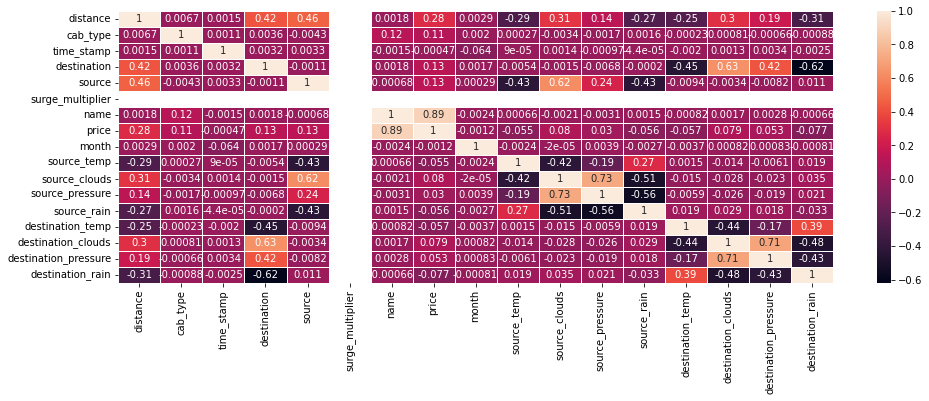

In [54]:
corr = dataTest.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(corr, annot=True, linewidths=1)
top_feature = corr.index[abs(corr['price']) > 0.2]
print(top_feature)
dataTest = dataTest[top_feature]
dataTrain = dataTrain[top_feature]


### Model training and result

In [55]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=10)
X_train = dataTrain.drop(['price'],axis=1)
X_test = dataTest.drop(['price'],axis=1)
y_train = dataTrain.price
y_test = dataTest.price

In [56]:
scaler = MinMaxScaler()
scaler.fit(X_train)
pickle.dump(scaler, open('scaler.pkl', 'wb'))
X_train = pd.DataFrame(scaler.transform(X_train), columns= dataTrain.drop(['price'],axis=1).columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns= dataTest.drop(['price'],axis=1).columns)


In [57]:
def model_trial(X_train, X_test, y_train, y_test, model, degree=30):
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    pickle.dump(poly_features, open(f'poly_features.pkl', 'wb'))
    model.fit(X_train_poly, y_train)
    pickle.dump(model, open('linear.pkl', 'wb'))
    y_train_predicted = model.predict(X_train_poly)
    prediction = model.predict(poly_features.fit_transform(X_test))
    train_err = metrics.mean_squared_error(y_train, y_train_predicted)
    test_err = metrics.mean_squared_error(y_test, prediction)
    train_acc = metrics.r2_score(y_train,y_train_predicted)
    test_acc = metrics.r2_score(y_test,prediction)
    print('Train subset (MSE) for degree {}: '.format(degree), train_err)
    print('Test subset (MSE) for degree {}: '.format(degree), test_err)
    # print("R^2 for train ", train_acc)
    # print("R^2 for test ", test_acc)


In [58]:
def corssValidation(X_train, X_test, y_train, y_test,model, degree=1):
    modelfeatures = PolynomialFeatures(degree)
    # transforms the existing features to higher degree features.
    X_train_poly_model_1 = modelfeatures.fit_transform(X_train)
    # fit the transformed features to Linear Regression
    poly_model1 = model
    scores = cross_val_score(poly_model1, X_train_poly_model_1, y_train, scoring='neg_mean_squared_error', cv=9)
    model_1_score = abs(scores.mean())
    poly_model1.fit(X_train_poly_model_1, y_train)
    print("model cross validation score is "+ str(model_1_score))
    # predicting on test data-set
    prediction = poly_model1.predict(modelfeatures.fit_transform(X_test))
    print('model Test Mean Square Error', metrics.mean_squared_error(y_test, prediction))

In [59]:
deg = 9
model_trial(X_train, X_test, y_train, y_test, linear_model.LinearRegression(),deg)


Train subset (MSE) for degree 9:  2.0183723212556792
Test subset (MSE) for degree 9:  2.0491802480209778


In [60]:
#model_trial(X_train, X_test, y_train, y_test, linear_model.Ridge(), deg)


In [61]:
corssValidation(X_train, X_test, y_train, y_test, linear_model.LinearRegression(),degree=5)
corssValidation(X_train, X_test, y_train, y_test,linear_model.Ridge(),degree=5)

model cross validation score is 2.079568104105995
model Test Mean Square Error 2.0919013637316586
model cross validation score is 2.1126513972878302
model Test Mean Square Error 2.1239051959884887


In [62]:
test_sample(pd.read_csv('taxi-test-samples.csv'))

linear acc 87.57513458296407


/tmp/ipykernel_106646/2079679277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleData.drop(['price'], axis=1, inplace=True)
/tmp/ipykernel_106646/2079679277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleData[col] = encoder.transform(sampleData[col])
/home/ayman/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
